<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

In [2]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Дисклеймер про CrossEntropyLoss и NLLLoss

Обычно в PyTorch не нужно делать Softmax как последний слой модели. 

* Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)
* Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss

Зачем такие сложности, чтобы посчитать обычную кросс энтропию, которую мы использовали как лосс еще в логистической регрессии? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность. 

Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В этой домашке везде используется лосс CrossEntropy

# 1. Создайте генератор батчей. 

В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении. 

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch)


**Ответ на задание - код**

In [3]:
'''
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    X=X[perm]
    y=y[perm]
    for i in range(X.shape[0]//batch_size+1):
        yield (X[batch_size*i:batch_size*(i+1)], y[batch_size*i:batch_size*(i+1)])
'''
'''        
def batch_generator(X,y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    
    for i in range(0, len(X), batch_size):
        idxs = perm[i: i+batch_size]
        yield X[idxs], y[idxs]
'''       
        
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    X,y=X[perm],y[perm]
    for i in range(0, len(X), batch_size):
         yield X[i:min(i + batch_size, len(X))], y[i:min(i + batch_size, len(X))]

# 2. Обучите модель для классификации звезд

Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam со lr=1e-2. 

**В качестве ответа введите число - среднее предсказание 0 класса на тестовом датасете (т.е. выход модели для 0 класса, где среднее берется по предсказаниям для всех строчек из теста)**

In [4]:
import numpy as np

В датасете классы - строчки, поэтому чтобы ответ совпал с ответом на степике надо каким-то детерминированным образом его закаодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число.

In [5]:
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

In [6]:
data = pd.read_csv('./sky_data.csv')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [7]:
# Extract Features
X = data[feature_columns]
# Extract target
y = data[target_column]
# encode target with target_mapping
y = y.map(target_mapping)

Нормализация фичей

In [8]:
X = (X - X.mean()) / X.std()

Обучение

In [9]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train = torch.FloatTensor(X_train.values)
y_train = torch.LongTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.LongTensor(y_test.values)

X_train.size()


torch.Size([7500, 10])

In [10]:
torch.manual_seed(42) 
'''
Dense Layer с relu активацией и 50 нейронами
Dropout with 50% keep rate
BatchNorm
Dense Layer с relu активацией и 100 нейронами
Dropout with 50% keep rate
BatchNorm
Выходной Dense слой c количеством нейронов, равному количеству классов

'''

model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(50),
    nn.Linear(50,100),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(100),
    nn.Linear(100, 3)
)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)

Теперь обучим модель

In [11]:
def train(num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            
            # предсказание 
            pred = model(X_batch)
            
            # зануляем градиент
            optimizer.zero_grad()
            
            loss = loss_fn(pred, y_batch)
            loss.backward()

            # ОБНОВЛЯЕМ веса 
            optimizer.step()
            
            # Запишем число (не тензор) в наши батчевые лоссы
            train_losses.append(loss.data.item())
            
            # Теперь посчитаем лосс на тесте
            model.train(False)
            
            #  число равное лоссу на всем тест датасете
            p_test = model(X_test)
            test_losses.append(loss_fn(p_test, y_test).item())

    return train_losses, test_losses

In [12]:
train_losses, test_losses = train(20)

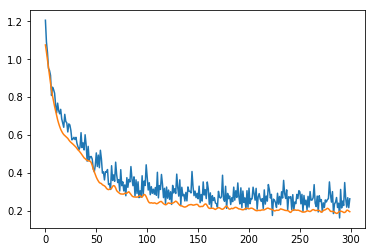

In [13]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(test_losses)), test_losses)

In [14]:
# Ответ на задачу
model.train(False)
y_pred = model(X_test)  
p_mean = y_pred[:,0].mean().item()
p_mean

1.6389087438583374

# Задание 3

Только что вы обучили полносвязную нейронку, сейчас попробуйте исправить ошибки в созданных ниже нейронках и потом обучить их с помощью той же функции train. Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).

Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:

1. Если вы видите лишний не линейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сдлеать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 
6. Любые другие проблемы решаются более менее однозначно, если же у вас есть серьезные сомнения, то напишите в беседу в телеграме и пинганите меня @runfme


Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

**Ответ на задачу - средний лосс на тестовом датасете**

In [15]:
torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    #nn.Dropout(p=0.5),
    nn.Linear(50, 200),
    nn.ReLU(),
   # nn.Softmax(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
   # nn.Dropout(p=0.5)
)

#model.parameters[:-2]
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

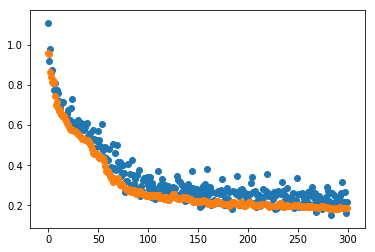

In [16]:
train_losses, test_losses = train(20)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)

In [117]:
# Ответ на задачу 
sum(test_losses)/len(test_losses)

0.29510903934637706